# Convolutional Neural Network (CNN)

In [1]:
import collections
from collections import Counter
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pyedflib
import pywt
import random
import re
from scipy import signal
from sklearn import metrics
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing

Download the dataset

In [2]:
def randomly_split_records(dataset_stats):
  np.random.seed(1000)
  
  n_train = round(0.60 * len(dataset_stats))
  n_val = round(0.80 * len(dataset_stats))
  random.shuffle(dataset_stats)
  return dataset_stats[:n_train], dataset_stats[n_train:n_val], dataset_stats[n_val:]

In [3]:
def get_dataset_stats(chb):
  np.random.seed(1000)

  dataset_root = fr"C:\Users\assaa\Documents\ECE496\Datasets\chb-mit-scalp-eeg-database-1.0.0\chb-mit-scalp-eeg-database-1.0.0\chb{chb:02}"
  summary_list = []

  for root, dir, files in os.walk(dataset_root, topdown=False):
    for name in files:
      if re.search(r'-summary.txt', name):
        summary_list.append((root, os.path.join(root, name)))


  train_seizure_records = []
  train_interictal_records = []
  test_seizure_records = []
  test_interictal_records = []
  val_seizure_records = []
  val_interictal_records = []

  for root, summary_path in summary_list:
    if (root[-5:] == "chb24"):
      break
    
    summary_text = open(summary_path, "r").read()
    parsed_summary = re.split("\n\n", summary_text)[2:]
    seizure_numbers = re.findall(r'Number of Seizures in File: (.)', summary_text)
    max_seizures_file = max([int(x) for x in seizure_numbers])

    # print(parsed_summary)

    seizure_records = []
    interictal_records = []

    for summary in parsed_summary:
      file_name = re.search(r'File Name: (.*?)\n', summary)
      if file_name:
        file_name = os.path.join(root, file_name.group(1))
        seizure_durations = []

        num_seizures = re.search(r'Number of Seizures in File: (.)', summary).group(1)
        num_seizures =  int(num_seizures)
        
        if(num_seizures > 0):
          if max_seizures_file < 2:
            seizure_start_time = re.search(r'Seizure Start Time: (.*?) seconds\n', summary)
            seizure_end_time = re.search('Seizure End Time: (.*?) seconds', summary)
            if seizure_start_time:
              seizure_start_time = int(seizure_start_time.group(1)) * 256
              seizure_end_time = int(seizure_end_time.group(1)) * 256
              seizure_durations.append((seizure_start_time, seizure_end_time))
            else:
              seizure_start_time = int(re.search(r'Seizure 1 Start Time: (.*?) seconds\n', summary).group(1)) * 256
              seizure_end_time = int(re.search('Seizure 1 End Time: (.*?) seconds', summary).group(1)) * 256
              seizure_durations.append((seizure_start_time, seizure_end_time))
          else:
            for i in range(num_seizures):
              seizure_num = i + 1
              seizure_start_time = re.search(r'Seizure %i Start Time: (.*?) seconds\n'%(seizure_num), summary)
              seizure_end_time = re.search('Seizure %i End Time: (.*?) seconds'%(seizure_num), summary)
              if seizure_start_time:
                seizure_start_time = int(seizure_start_time.group(1)) * 256
                seizure_end_time = int(seizure_end_time.group(1)) * 256
                seizure_durations.append((seizure_start_time, seizure_end_time))
              else:
                seizure_start_time = int(re.search(r'Seizure Start Time: (.*?) seconds\n', summary).group(1)) * 256
                seizure_end_time = int(re.search('Seizure End Time: (.*?) seconds', summary).group(1)) * 256
                seizure_durations.append((seizure_start_time, seizure_end_time))
          seizure_records.append([file_name, num_seizures, seizure_durations])
        else:
          interictal_records.append([file_name, num_seizures, seizure_durations])

    random.shuffle(seizure_records)
    random.shuffle(interictal_records)

    train_s, val_s, test_s = randomly_split_records(seizure_records)
    train_i, val_i, test_i = randomly_split_records(interictal_records)

    train_seizure_records += train_s
    val_seizure_records += val_s
    test_seizure_records += test_s
    train_interictal_records += train_i
    val_interictal_records += val_i
    test_interictal_records += test_i

  # print("Appending 80% train split for ", summary_path)

  # train_records = train_seizure_records + train_interictal_records
  # val_records = val_seizure_records
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)

In [4]:
def load_train_seizure_data(stats):
  file_paths = stats[:,0]
  ictal_segments = []

  for index, path in enumerate(file_paths):
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    for i in range(n):
      signal = f.readSignal(i, digital=True)
      num_segments = math.ceil(len(signal) / 1280) * 10

      for duration in stats[index][2]:
        start = math.ceil(duration[0] / 5)
        end = math.floor(duration[1] / 5)

        ictal_segments += [(path, i, num_segments, x, 1) for x in range(start, end + 1)]
    f.close()
  return ictal_segments

def load_train_interictal_data(stats):
  interictal_stats = []

  for path in stats:
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    for i in range(n):
      signal = f.readSignal(i, digital=True)
      num_segments = math.ceil(len(signal) / 1280) * 10
      interictal_stats += [(path, i, num_segments, x, 0) for x in range(num_segments)]
    f.close()
  return interictal_stats

In [5]:
def is_abnormal(index, seg_size, durations):
  for duration in durations:
    seizure_start = duration[0]
    seizure_end = duration[1]
    seg_start = index
    seg_end = index + seg_size

    if seizure_start <= seg_start <= seizure_end or seg_start <= seizure_start <= seg_end:
      return True

  return False

def segment(signal, durations, is_seizure_record):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    need_last_seg = True

    while index <= len(signal) - 1280:
      if index + seg_size == len(signal) - 1:
        need_last_seg = False

      
      # print("segment called")
      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      if is_abnormal(index, seg_size, durations) and is_seizure_record:
        # print("Abnormal segment")
        segment = signal[index:index + seg_size]
        # features = get_dwt_features(segment)
        segments.append((segment, 1))
      elif not is_seizure_record:
        # print("interictal segment")
        segment = signal[index:index + seg_size]
        # features = get_dwt_features(segment)
        segments.append((segment, 0))

      index += math.ceil(overlap * seg_size)

    if need_last_seg:
      
      if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations) and is_seizure_record:
        segment = signal[-seg_size:]
        segments.append((segment, 1))
        # labels.append(1)
      elif not is_seizure_record:
        segment = signal[-seg_size:]
        segments.append((segment, 0))
        # labels.append(0)

    #return segments array and take a few and convert into scalograms during
    #training

    return segments

def load_data(stats, is_seizure_record):
  file_names = stats[:,0]
  # print(file_names)
  dataset = []
  seg_size = 1280

  X_data = []
  # Y_data = []

  for index, name in enumerate(file_names):
    # print(name)
    # if name in file_names:
    # index = np.where(file_names == name)[0][0]
    f = pyedflib.EdfReader(name)
    n = f.signals_in_file
    for i in range(n):
      signal = f.readSignal(i, digital=True)

      # if is_seizure_record:
      # print(stats[index][2])
          # start = math.ceil(duration[0] / 5)
          # end = math.floor(duration[1] / 5)
      segments = segment(signal, stats[index][2], is_seizure_record)
      X_data += segments
          # print("segments:")
          # print(segments)
          # Y_data += labels
      # else:
      #   segments = segment(signal, [], is_seizure_record)
      #   # num_segments = math.ceil(len(signal) / 1280)
      #   X_data += segments
        
    f.close()
    # dataset += [(name, X_data, Y_data, stats[index][2]))
  return X_data

# dataset = load_data(dataset_stats)

In [6]:
def under_sample_new(stats, number):
  print("Executing under sampling")
  records = load_data(stats, False)
  print(len(records))
  records = random.sample(records, number)
  print(len(records))
  return list(records)

In [ ]:
train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats()

# train_records = np.concatenate((train_seizure_records, train_interictal_records))
# val_records = np.concatenate((val_seizure_records, val_interictal_records))

if len(val_seizure_records) != 0:
  train_seizure_records_plus_val = np.concatenate((train_seizure_records, val_seizure_records))
else:
  train_seizure_records_plus_val = train_seizure_records
  val_seizure_records = np.array([train_seizure_records[0].tolist()])

# train_plus_val_records = np.concatenate((train_records, val_records))

train_interictal_records_plus_val = np.concatenate((train_interictal_records, val_interictal_records))

TypeError: ignored

Download the dataset

In [ ]:
#Training and validation data put together for the unsupervised stage.

X_data = load_data(train_seizure_records_plus_val, True)
# print(len(X_data))
X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
print(X_data)
X_train_all = X_data[:,0]



# #Training and validation data separated for the supervised stage.

X_data = load_data(train_seizure_records, True)
X_data += under_sample_new(train_interictal_records, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_train = X_data[:,0]
Y_train = X_data[:,1]

X_data = load_data(val_seizure_records, True)
X_data += under_sample_new(val_interictal_records, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_val = X_data[:,0]
Y_val = X_data[:,1]

Executing under sampling
4493648
1242
[[array([79, 77, 86, ..., 47, 41, 27]) 1]
 [array([-390, -702, -494, ...,   66,   42,   68]) 0]
 [array([ 6, 18, 22, ..., 59, 25, 11]) 1]
 ...
 [array([  3,   0,   4, ..., 204, 158, 133]) 0]
 [array([-121, -153, -120, ..., -110,  -43,   38]) 1]
 [array([155, 158, 169, ...,  77,  88,  91]) 1]]


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
3335736
805


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
1157912
437


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


In [ ]:
X_data=np.asarray(X_data)

C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\41022765.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data=np.asarray(X_data)


In [ ]:
print(X_data[:,0])

[array([-209, -211, -225, ...,   34,   27,   25])
 array([ 97, 101,  88, ..., 386, 396, 385])
 array([-120, -127, -146, ...,   85,   97,   94]) ...
 array([ 85,  76,  74, ..., -66, -72, -67])
 array([55, 42, 38, ..., 66, 66, 62]) array([40, 36, 45, ..., 36, 16,  1])]


In [ ]:
print(X_data)

[(array([-209, -211, -225, ...,   34,   27,   25]), 1), (array([ 97, 101,  88, ..., 386, 396, 385]), 1), (array([-120, -127, -146, ...,   85,   97,   94]), 1), (array([ 31,  45,  41, ..., -11,  -1,   0]), 1), (array([  49,   31,   -6, ..., -157, -184, -221]), 1), (array([ 231,  246,  250, ...,  -54,  -91, -130]), 1), (array([59, 79, 89, ..., 11, 16, 12]), 1), (array([-179, -173, -182, ...,  -54,  -43,  -39]), 1), (array([180, 179, 166, ...,  39,  48,  41]), 1), (array([  7,  19,  16, ..., -46, -40, -49]), 1), (array([-30, -39, -33, ..., -52, -44, -34]), 1), (array([141, 124, 129, ...,  83,  87,  90]), 1), (array([-124, -123,  -99, ...,  -89,  -96,  -96]), 1), (array([-70, -75, -61, ..., 110, 113, 124]), 1), (array([-27, -62, -68, ...,  82,  80,  78]), 1), (array([-187, -203, -187, ...,    0,  -26,  -39]), 1), (array([ 194,  193,  193, ..., -117, -108,  -89]), 1), (array([-117, -141, -133, ...,  215,  234,  260]), 1), (array([55, 41, 39, ..., 53, 47, 49]), 1), (array([ 76,  65,  76, ...

In [ ]:
print(len(X_data))

2484


In [ ]:
X_data

array([[432, 0],
       [array([ -17,  -20,  -26, ..., -102, -108, -104]), 1],
       [663, 0],
       ...,
       [array([212, 212, 201, ..., 213, 216, 226]), 1],
       [array([-98, -93, -88, ..., -51, -70, -76]), 1],
       [496, 0]], dtype=object)

In [ ]:
print(len(X_data))

943


In [ ]:
# #Training and validation data put together for the unsupervised stage.

# X_data = load_train_seizure_data(train_seizure_records_plus_val)
# X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_train_all = X_data[:,:4]



# #Training and validation data separated for the supervised stage.

# X_data = load_train_seizure_data(train_seizure_records)
# X_data += under_sample_new(train_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_train = X_data[:,:4]
# Y_train = X_data[:,4]

# X_data = load_train_seizure_data(val_seizure_records)
# X_data += under_sample_new(val_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_val = X_data[:,:4]
# Y_val = X_data[:,4]

7727770
1127
6188610
1127
1539160
460


## CWT to generate scalograms for time-frequency representation, i.e. 2D-CNN

In [7]:
def get_cwt_features(sample):
    f = pyedflib.EdfReader(sample[0])
    n = f.signals_in_file

    chn = int(sample[1])
    num_segments = int(sample[2])
    index = int(sample[3])

    signal = f.readSignal(chn, digital=True)
    segments = np.array_split(signal, num_segments)

    coef, _ =pywt.cwt(segments[index], np.arange(2,67),'morl', sampling_period=0.00390625) # Primary paper followed used Morelet mother wave
    coef.resize((22, 1280)) 
    f.close()
    return coef

def get_cwt(segment):
    coef, _ =pywt.cwt(segment, np.arange(2,67),'morl', sampling_period=0.00390625) # Primary paper followed used Morelet mother wave
    coef.resize((22, 1280)) 
    return coef

* label EEG segments
* segment the EEG segments
* use CWT to generate scalograms
* split scalograms into testing/train for input and output sets

* 289 : number of segments
* 21 : range of sizes embedded into the CWT
* 1279 : number of samples 

## Stacked Autoencoder Model

Loading state to model with new layers: 

https://stackoverflow.com/questions/70986805/how-to-save-and-load-only-particular-layers-of-a-neural-network-with-pytorch

https://pytorch.org/tutorials/beginner/saving_loading_models.html


## Training

# Supervised

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Convert Data Supervised

## Classifier Model

Now that we have finished the unsupervised training stage of the stacked autoencoder, we need to freeze the weights of its encoder layers for the next stage which is replacing the decoder layers with a classifier and fine tuning it using supervised training.

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        self.name = "CNN"
        self.pool = nn.MaxPool2d(3, stride=1, return_indices=False)
        self.conv1 = nn.Conv2d(1, 4, 3, 1)   # in_channels, out_channels, kernal_size, stride
        self.conv2 = nn.Conv2d(4, 8, 3, 1)   
        self.conv3 = nn.Conv2d(8, 16, 3, 1)

        self.fc1 = nn.Linear(16 * 10 * 1268, 32)
        self.fc2 = nn.Linear (32, 16)
        self.fc3 = nn.Linear (16, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 16 * 10 * 1268)
        x = self.fc1(x)
        x = F.relu(x)  
        x = self.fc2(x)
        x = F.relu(x)  
        x = self.fc3(x)        
        return x

In [9]:
def train_classifier(net, chb, X_train, X_val, Y_train, Y_val, batch_size=24, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/acurracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    val_accs = []
    train_accs = []
    iters = []
    iterations = 0
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        train_acc = 0      # training accuracy per batch
        pred = 0
        corr = 0
        tot = 0
        
        val_acc = 0        # validation accuracy per batch
        pred_val = 0
        corr_val = 0
        tot_val = 0

        count = 0
        
        # Training dataset
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], batch_size):
            batch = train_indices[it:(it + batch_size)]
            X = torch.Tensor(np.array([[get_cwt(x)] for x in X_train[batch]]))
            X = X.cuda()
            Y = torch.Tensor(Y_train[batch].astype(np.int32))
            Y = Y.cuda()
            
            # print(inputs)

            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(X)
            loss = criterion(outputs, Y.long())
            loss.backward()
            optimizer.step()

            # get training accuracy
            pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
            corr += pred.eq(Y.view_as(pred)).sum().item()
            tot += Y.shape[0]

            count += 1
            print("Batch ", count, " complete.")
        # training accuracy
        train_acc = corr / tot

        # Validation dataset
        print("Validating...")

        val_indices = np.arange(len(X_val)) 
        np.random.shuffle(val_indices)
        for it in range(0, X_val.shape[0], batch_size):
            batch = val_indices[it:(it + batch_size)]
            X = torch.Tensor(np.array([[get_cwt(x)] for x in X_val[batch]]))
            X = X.cuda()
            Y = torch.Tensor(Y_train[batch].astype(np.int32))
            Y = Y.cuda()
            
            outputs = net(X)
            pred_val = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
            corr_val += pred_val.eq(Y.view_as(pred_val)).sum().item()
            tot_val += Y.shape[0]
        # validation accuracy
        val_acc = corr_val / tot_val

        print("Epoch ", epoch+1, " - Train: ", train_acc, "Val: ", val_acc)
        print()
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        iters.append(iterations)
        
        
    plt.title("Accuracy Curve")
    plt.plot(range(1,len(train_accs)+1), train_accs, label="Train")
    plt.plot(range(1,len(val_accs)+1), val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig(fr'C:\Users\assaa\Documents\ECE496\Testing\TrainingPlots\CNN\training_chb{chb:02}_new.png')
    plt.show()

    print("Final Training Accuracy: {}".format(train_accs[-1]))
    print("Final Validation Accuracy: {}".format(val_accs[-1]))
    
    print()
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_min = elapsed_time / 60
    print("Total time elapsed: {:.2f} minutes".format(time_min))

In [ ]:
#Run this to close all the files
# for i in range(10):
for root, dir, files in os.walk(dataset_root, topdown=False):
  # print(dir)
  for f in files:
      if f[-3:] == "edf":
        fd = open(os.path.join(root, f))
        fd.close()

        # if fd.closed:
        #   print(f, "is closed")

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

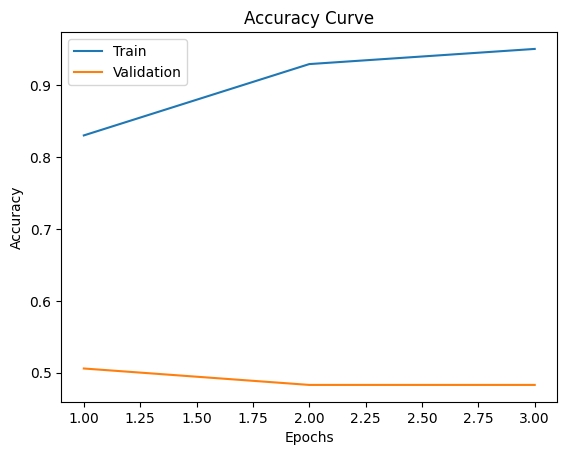

Final Training Accuracy: 0.9509316770186336
Final Validation Accuracy: 0.482837528604119

Total time elapsed: 1.01 minutes


<Figure size 640x480 with 0 Axes>

In [ ]:
# cnn_model = CNN()
# classifier = Classifier()
classifier.cuda()

train_classifier(classifier, 1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=3)

In [ ]:
torch.save(classifier.state_dict(), r"C:\Users\assaa\Documents\ECE496\Models\CNN\classifier_chb"+chb+"_32bs_2epochs_v2.pth")

In [ ]:
classifier = Classifier()
classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb01_32bs_2epochs_v2.pth"))

<All keys matched successfully>

# Validation Methods

In [10]:
#This version of segment() returns all seizure segments but also returns
#all non-seizure segments after each seizure interval up to the number
#of segments in that interval. This way there is a 50:50 split between
#seizure and non-seizure segments.
def segment_test(signal, durations):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    # need_last_seg = True

    num_seizure_durations = len(durations)
    seizure_duration_count = 0
    num_seizures = 0
    num_interictal = 0

    while index <= len(signal) - 1280:
      # if index + seg_size == len(signal) - 1:
      #   need_last_seg = False

      
      # print("segment called")
      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      # for duration in durations:
      if is_abnormal(index, seg_size, durations):
        segment = signal[index:index + seg_size]
        segments.append((segment, 1))
        num_seizures += 1
      else:
        if num_interictal < num_seizures and num_seizures > 0:
          segment = signal[index:index + seg_size]
          segments.append((segment, 0))
          num_interictal += 1
        else:
          if num_seizures > 0:
            seizure_duration_count += 1
            if seizure_duration_count == num_seizure_durations:
              break

          num_seizures = 0
          num_interictal = 0

      index += math.ceil(overlap * seg_size)

    # if need_last_seg:
      
    #   if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations):
    #     segment = signal[-seg_size:]
    #     segments.append((segment, 1))
    #   else:
    #     segment = signal[-seg_size:]
    #     segments.append((segment, 0))

    #return segments array and take a few and convert into scalograms during
    #training

    return segments

In [11]:
#Load the test data for the record file.
def load_test_data(stat):
  X_data = []

  f_path = stat[0]
  seizure_durations = stat[2]

  f = pyedflib.EdfReader(f_path)
  n = f.signals_in_file
  for i in range(n):
    signal = f.readSignal(i, digital=True)
    segments = segment_test(signal, stat[2])
    X_data += segments
  f.close()
  return X_data

In [12]:
#This function is the same as label_record() but without irrelevant
#operations to acquiring sampling speed, such as comparing predictions.
#Also it takes timestamps and records number of samples per segment to
#get the labelling speed.
def label_record_speed(net, record, load_func, batch_size=1):
  # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    start_time = time.time()

    test_data = load_func(record)

    test_data = np.asarray(test_data)

    segment_arr = test_data[:,0]

    seizure_durations = record[2]

    pred = 0
    total_samples = 0

    #Testing
    train_indices = np.arange(len(segment_arr))
    for it in range(0, segment_arr.shape[0], batch_size):
      batch = train_indices[it:(it + batch_size)]
      X_test = torch.Tensor(np.array([[get_cwt(x)] for x in segment_arr[batch]]))
      # print("New batch")
      # print(len(segment_arr[batch][0]))
      X_test = X_test.cuda()
      total_samples += len(segment_arr[batch][0])

      outputs = net(X_test)
      pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    rate = total_samples / elapsed_time

    # with open(r'C:\Users\assaa\Documents\ECE496\test_results.txt', 'w') as sys.stdout:
    print("Record: ", record)
    print("Speed: ", rate)
    
    return rate

In [13]:
#Return the labelling rate of the model.
def test_speed(net, test_records, save_file, load_func):
  total_rates = 0
  num_records = 0

  
  for record in test_records:
    net.cuda()
    rate = label_record_speed(net, record, load_func)
    num_records += 1
    total_rates += rate
  
  #Average rate.
  total_rates /= num_records

  print("\nAverage speed: " + str(total_rates))

  test_f = open(save_file, "a")
  test_f.write("Average speed: " + str(total_rates) + "\n")
  test_f.close()
  # return total_rates

In [14]:
def get_overlap(start_1, end_1, start_2, end_2):
  return range(max(start_1, start_2), min(end_1, end_2))

def is_overlaping(start_1, end_1, start_2, end_2):
  if len(get_overlap(start_1, end_1, start_2, end_2)):
    return True
  return False

#Predicted seizure intervals.
def calculate_seziure_times(labels, tolerance=5):
  start = None
  count = 0
  seizures = []
  for (index, label) in enumerate(labels):
    if label:
      if not start:
        start = index * 128
    else:
      if start:
        count += 1
        if count == tolerance:
          seizures.append((start, index * 128))
          start = None
          count = 0
  return seizures

#Calculate the latency measurement.
def calculate_latency(seizure_durations, seizure_times):
  count = 0
  S = len(seizure_durations)
  latency = 0

  if S == 0:
    return -1

  for (seizure_start, seizure_end) in seizure_durations:
    for (start, end) in seizure_times:
      overlap = get_overlap(seizure_start, seizure_end, start, end)
      if len(overlap):
        latency += (overlap[0] - seizure_start) / 256
        count += 1
        break

  if count == 0:
    return -1

  return latency / count

#Calculate sensitivity.
def calculate_sensitivity(seizure_durations, seizure_times):
  count = 0
  S = len(seizure_durations)

  if S == 0:
    return -1

  if len(seizure_times) == 0:
    return -1
  
  for (seizure_start, seizure_end) in seizure_durations:
    detected = False
    for (start, end) in seizure_times:
      if is_overlaping(seizure_start, seizure_end, start, end):
        count += 1
        break
  return count / S

#Calculate FPR.
def calculate_false_pos_rate(Y_test, Y_pred):
  count = 0
  N = len([label for label in Y_test if label == 0])

  for i in range(len(Y_pred)):
    if Y_pred[i] and not Y_test[i]:
      count += 1

  return 3600 * 256 * (count / N)

In [15]:
def evaluate(model, record, load_func, capture_saliency=False, batch_size=32):

  test_data = load_func(record)
  test_data = np.asarray(test_data)

  segment_arr = test_data[:,0]
  true_label_arr = test_data[:,1]

  idx = 0

  seizure_durations = record[2]

  predictions = []

  #Testing
  train_indices = np.arange(len(segment_arr))
  for it in range(0, segment_arr.shape[0], batch_size):
    batch = train_indices[it:(it + batch_size)]
    X_test = torch.Tensor(np.array([[get_cwt(x)] for x in segment_arr[batch]]))
    X_test = X_test.cuda()


    Y_test = true_label_arr[batch].tolist()

    outputs = model(X_test)
    # print(outputs)
    pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
    pred_list = pred.cpu().squeeze().tolist()
    predictions += pred_list

    if capture_saliency:
      for i in range(len(pred_list)):
        
        # if idx <= 17582:
        #   idx += 1
        #   continue

        #Save the scalogram image and saliency map for each segment.

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        scalogram = X_test[i]
        scalogram.reshape(1, 1, 220, 128)
        scalogram = scalogram.to(device)
        scalogram.requires_grad_()

        # Retrieve output from the image
        output = model(scalogram)


        if Y_test[i]:
          truth_str = "Seizure"
        else:
          truth_str = "Non-seizure"
        if pred_list[i]:
          pred_str = "Seizure"
        else:
          pred_str = "Non-seizure"


        pred = output.max(1, keepdim=True)[1]
        title = "Truth: " + truth_str + "\nPrediction: " + pred_str


        output_idx = output.argmax()
        output_max = output[0, output_idx]


        output_max.backward()

        saliency = scalogram.grad.data.abs()
        saliency = saliency.reshape(220, 128)

        scalogram = scalogram.reshape(-1, 220, 128)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(scalogram.cpu().detach().numpy().transpose(1, 2, 0))
        ax[0].axis('off')
        ax[1].imshow(saliency.cpu(), cmap='hot')
        ax[1].axis('off')
        fig.suptitle(title)

        #Save to the folder based on if it is FP, FN, TP, or TN.
        if pred_list[i] and not Y_test[i]:
          fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\FalsePositive\segment' + str(idx) + '.png')
        elif not pred_list[i] and Y_test[i]:
          fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\FalseNegative\segment' + str(idx) + '.png')
        elif pred_list[i] and Y_test[i]:
          fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\TruePositive\segment' + str(idx) + '.png')
        elif not pred_list[i] and not Y_test[i]:
          fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\TrueNegative\segment' + str(idx) + '.png')
        
        # plt.show()

        idx += 1

  #Calculate and return seizure times.
  seizure_times = calculate_seziure_times(predictions)

  # Evaluation Metrics
  latency = calculate_latency(seizure_durations, seizure_times)
  sensitivity = calculate_sensitivity(seizure_durations, seizure_times)
  false_pos_rate = calculate_false_pos_rate(true_label_arr, predictions)

  print("Record: ", record)
  print("Latency: ", latency)
  print("Sensitivity: ", sensitivity)
  print("FPR: ", false_pos_rate)
  print()

  return latency, sensitivity, false_pos_rate

In [ ]:
#Run this to close all the files
# for i in range(10):
dataset_root = fr"C:\Users\assaa\Documents\ECE496\Datasets\chb-mit-scalp-eeg-database-1.0.0\chb-mit-scalp-eeg-database-1.0.0\chb02"
for root, dir, files in os.walk(dataset_root, topdown=False):
  # print(dir)
  for f in files:
      if f[-3:] == "edf":
        fd = open(os.path.join(root, f))
        fd.close()

        # if fd.closed:
        #   print(f, "is closed")

In [16]:
#This function tests the latency, sensitivity, and false positive rate
#of the model.
def test_accuracy(net, test_records, save_file, load_func, capture_saliency=False):
  total_latency = 0
  total_sensitivity = 0
  total_fpr = 0

  num_lat_records = 0
  num_sens_records = 0
  num_fpr_records = 0

  for record in test_records:
    print(record)
    net.cuda()
    
    #Return measurements for each record.
    lat, sens, fpr = evaluate(net, record, load_func, capture_saliency=capture_saliency)

    if lat != -1:
      total_latency += lat
      num_lat_records += 1
    
    if sens != -1:
      total_sensitivity += sens
      num_sens_records += 1

    total_fpr += fpr
    num_fpr_records += 1

  if num_lat_records == 0:
    total_latency = -1
  else:
    total_latency /= num_lat_records

  if num_sens_records == 0:
    total_sensitivity = -1
  else:
    total_sensitivity /= num_sens_records
  
  total_fpr /= num_fpr_records

  print("Average latency: " + str(total_latency))
  print("Average sensitivity: " + str(total_sensitivity))
  print("Average FPR: " + str(total_fpr))

  test_f = open(save_file, "a")
  test_f.write("Average latency: " + str(total_latency) + "\n")
  test_f.write("Average sensitivity: " + str(total_sensitivity) + "\n")
  test_f.write("Average FPR: " + str(total_fpr) + "\n")
  test_f.close()

  # return total_latency, total_sensitivity, total_fpr

In [17]:
def segment_test_all(signal, durations):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    need_last_seg = True

    while index <= len(signal) - 1280:
      if index + seg_size == len(signal) - 1:
        need_last_seg = False

      
      # print("segment called")
      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      if is_abnormal(index, seg_size, durations):
        segment = signal[index:index + seg_size]
        segments.append((segment, 1))
      else:
        segment = signal[index:index + seg_size]
        segments.append((segment, 0))

      index += math.ceil(overlap * seg_size)

    if need_last_seg:
      
      if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations):
        segment = signal[-seg_size:]
        segments.append((segment, 1))
      else:
        segment = signal[-seg_size:]
        segments.append((segment, 0))

    #return segments array and take a few and convert into scalograms during
    #training

    return segments

def load_test_data_all(stat):
  X_data = []

  f_path = stat[0]
  seizure_durations = stat[2]

  f = pyedflib.EdfReader(f_path)
  n = f.signals_in_file
  for i in range(n):
    signal = f.readSignal(i, digital=True)
    segments = segment_test_all(signal, stat[2])
    X_data += segments
  f.close()
  return X_data

In [ ]:
test_accuracy(classifier, test_interictal_records)

In [ ]:
test_accuracy(classifier, test_seizure_records)

In [ ]:
test_speed(classifier, test_seizure_records)

# Automated Training and Testing

In [ ]:
train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(2)

C:\Users\assaa\AppData\Local\Temp\ipykernel_27112\2211526169.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)


In [ ]:
test_seizure_records

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16.edf',
        1, list([(33280, 54272)])]], dtype=object)

In [ ]:
test_data = load_test_data(test_seizure_records[0])
test_data = np.asarray(test_data)

C:\Users\assaa\AppData\Local\Temp\ipykernel_27112\3085946810.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


In [ ]:
del test_data

In [ ]:
print(test_seizure_records[0])

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_15.edf'
 1 list([(443392, 453632)])]


In [ ]:
print(len(test_data))

8050


In [ ]:
#old test data length
print(len(test_data))

165416


In [ ]:
train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(1)

C:\Users\assaa\AppData\Local\Temp\ipykernel_14084\94771658.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)


In [ ]:
train_seizure_records_plus_val

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16+.edf',
        1, list([(760832, 781568)])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_19.edf',
        1, list([(862464, 864768)])]], dtype=object)

In [ ]:
if len(val_seizure_records) != 0:
  train_seizure_records_plus_val = np.concatenate((train_seizure_records, val_seizure_records))
else:
  train_seizure_records_plus_val = train_seizure_records
  val_seizure_records = np.array([train_seizure_records[0].tolist()])

# train_plus_val_records = np.concatenate((train_records, val_records))

train_interictal_records_plus_val = np.concatenate((train_interictal_records, val_interictal_records))

C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\1554084628.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_seizure_records = np.array([train_seizure_records[0].tolist()])


In [ ]:
train_seizure_records

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_18.edf',
        1, list([(1720, 1810)])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_26.edf',
        1, list([(1862, 1963)])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_15.edf',
        1, list([(1732, 1772)])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_21.edf',
        1, list([(327, 420)])]], dtype=object)

In [ ]:
X_data = load_data(train_seizure_records_plus_val, True)
# print(len(X_data))
X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_train_all = X_data[:,0]

Executing under sampling
4450546
1265


C:\Users\assaa\AppData\Local\Temp\ipykernel_14084\1561302094.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


In [ ]:
#before duration time fix
print(len(X_train_all))

2530


In [ ]:
print(len(X_train_all))

40020


In [ ]:
val_seizure_records[0]

array(['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16+.edf',
       1, list([(760832, 781568)])], dtype=object)

In [ ]:
val_interictal_records[0]

array(['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_32.edf',
       0, list([])], dtype=object)

In [ ]:
train_seizure_records

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16+.edf',
        1, list([(760832, 781568)])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_19.edf',
        1, list([(862464, 864768)])]], dtype=object)

In [ ]:
train_interictal_records

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_17.edf',
        0, list([])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_03.edf',
        0, list([])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_22.edf',
        0, list([])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_20.edf',
        0, list([])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_09.edf',
        0, list([])],
       ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_18.edf',
        0, lis

In [25]:
chb = 0
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\cnn_test_results.txt'

In [19]:
classifier = Classifier()
classifier.load_state_dict(torch.load(fr"C:\Users\assaa\Documents\ECE496\Models\CNN\cnn_chb{chb+1:02}_v4.pth"))

<All keys matched successfully>

In [26]:
#Tests for chb01

test_f = open(save_file, "a")
test_f.write(f"\n\n\nTest results for CHB{chb+1:02}:\n\n")
test_f.close()

# test_f.write("Seizure Accuracy:\n")

test_accuracy(classifier, test_seizure_records, save_file, load_test_data)
print("Seizure accuracy test complete.\n\n")

# test_speed(classifier, test_seizure_records, save_file, load_test_data)
# print("Seizure speed test complete.\n\n\n")

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\2402554830.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]
Latency:  -1
Sensitivity:  0.0
FPR:  329363.01958910655

Average latency: -1
Average sensitivity: 0.0
Average FPR: 329363.01958910655
Seizure accuracy test complete.




RUNNING ON CHB02



C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\2211526169.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)
C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\198581633.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_seizure_records = np.array([train_seizure_records[0].tolist()])


Executing under sampling
3308320
4692


C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\198581633.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
992496
4025
Initiating Training



C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\198581633.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

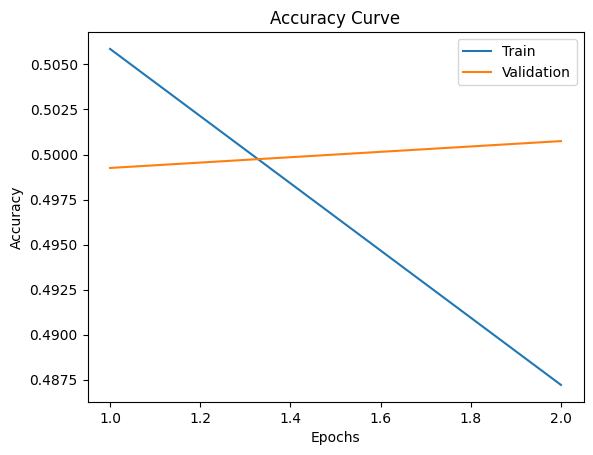

Final Training Accuracy: 0.48721227621483376
Final Validation Accuracy: 0.5007453416149068

Total time elapsed: 4.77 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16+.edf'
 1 list([(760832, 781568)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\2402554830.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16+.edf'
 1 list([(760832, 781568)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB03

Executing under sampling
3143180
10902
Executing under sampling
992496
6118
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  com

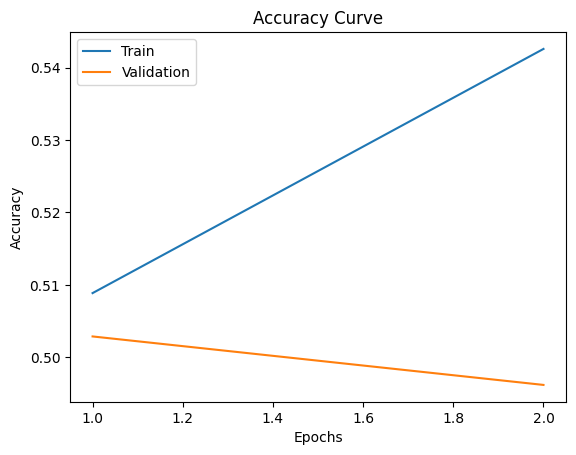

Final Training Accuracy: 0.5426068611263988
Final Validation Accuracy: 0.4961588754494933

Total time elapsed: 9.31 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb03\\chb03_02.edf'
 1 list([(187136, 203776)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb03\\chb03_02.edf'
 1 list([(187136, 203776)])]
Latency:  -1
Sensitivity:  -1
FPR:  921600.0

Average latency: -1
Average sensitivity: -1
Average FPR: 921600.0
Seizure accuracy test complete.


RUNNING ON CHB04

Executing under sampling
14592308
13499
Executing under sampling
5294608
10992
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  1

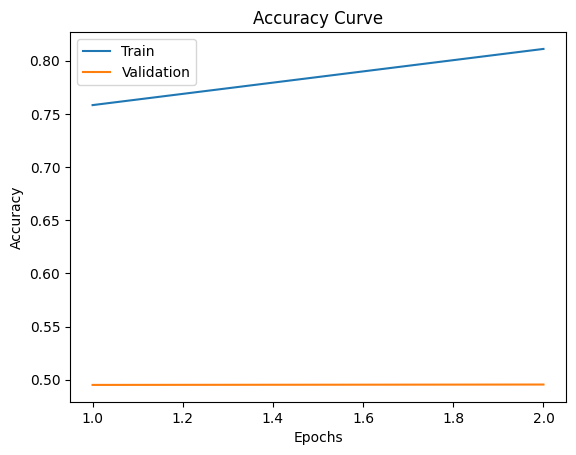

Final Training Accuracy: 0.8111341580857842
Final Validation Accuracy: 0.49540574963609896

Total time elapsed: 13.52 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_08.edf'
 1 list([(1650176, 1678592)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_08.edf'
 1 list([(1650176, 1678592)])]
Latency:  -1
Sensitivity:  0.0
FPR:  327965.6652360515

Average latency: -1
Average sensitivity: 0.0
Average FPR: 327965.6652360515
Seizure accuracy test complete.


RUNNING ON CHB05

Executing under sampling
3308780
16491
Executing under sampling
1157912
4669
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch

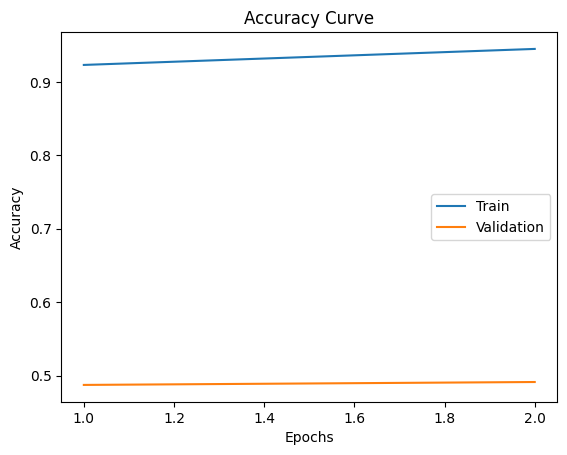

Final Training Accuracy: 0.944879024922685
Final Validation Accuracy: 0.4912186763760977

Total time elapsed: 11.65 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb05\\chb05_17.edf'
 1 list([(627456, 658176)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb05\\chb05_17.edf'
 1 list([(627456, 658176)])]
Latency:  61.5
Sensitivity:  1.0
FPR:  57949.21184825913

Average latency: 61.5
Average sensitivity: 1.0
Average FPR: 57949.21184825913
Seizure accuracy test complete.


RUNNING ON CHB06

Executing under sampling
4112492
5612
Executing under sampling
1324432
3151
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  1

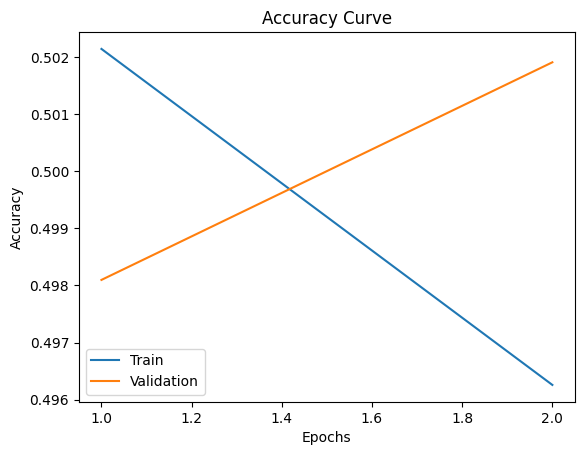

Final Training Accuracy: 0.49625801853171775
Final Validation Accuracy: 0.5019041574103459

Total time elapsed: 4.81 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb06\\chb06_18.edf'
 1 list([(1996544, 1999616)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb06\\chb06_18.edf'
 1 list([(1996544, 1999616)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB07

Executing under sampling
5738546
11500
Executing under sampling
1986648
6831
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  comp

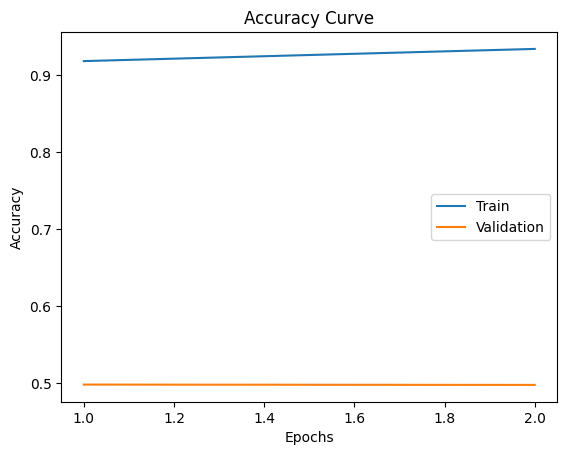

Final Training Accuracy: 0.9341304347826087
Final Validation Accuracy: 0.497364953886693

Total time elapsed: 9.99 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb07\\chb07_12.edf'
 1 list([(1259520, 1281536)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb07\\chb07_12.edf'
 1 list([(1259520, 1281536)])]
Latency:  -1
Sensitivity:  0.0
FPR:  159183.46400570206

Average latency: -1
Average sensitivity: 0.0
Average FPR: 159183.46400570206
Seizure accuracy test complete.


RUNNING ON CHB08

Executing under sampling
1489802
29509
Executing under sampling
496248
7613
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  

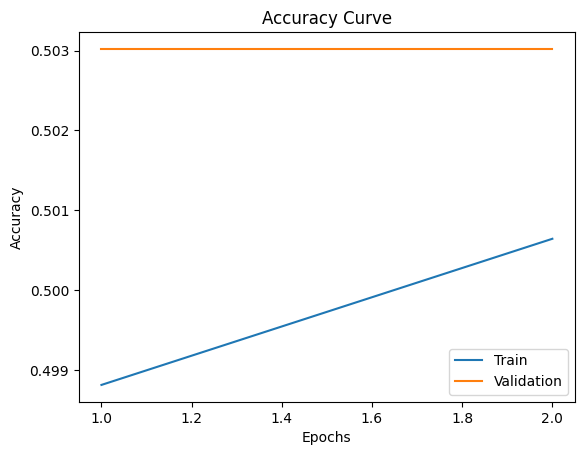

Final Training Accuracy: 0.5006438713612796
Final Validation Accuracy: 0.5030211480362538

Total time elapsed: 20.46 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb08\\chb08_11.edf'
 1 list([(764928, 799232)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb08\\chb08_11.edf'
 1 list([(764928, 799232)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB09

Executing under sampling
5905578
11064
Executing under sampling
2074032
3336
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete

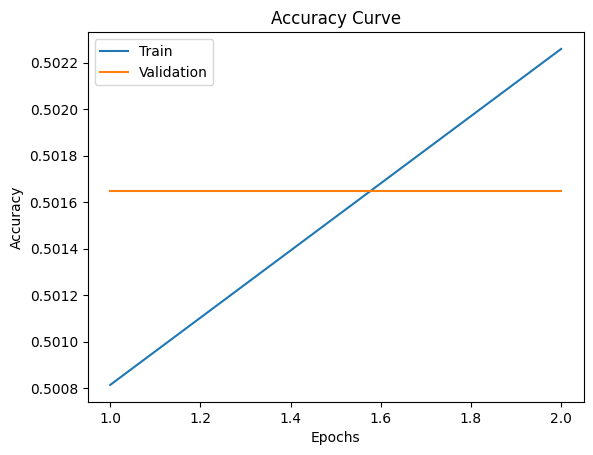

Final Training Accuracy: 0.5022595806218366
Final Validation Accuracy: 0.5016486810551559

Total time elapsed: 7.97 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb09\\chb09_19.edf'
 1 list([(1356544, 1372416)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb09\\chb09_19.edf'
 1 list([(1356544, 1372416)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB10

Executing under sampling
3641176
13386
Executing under sampling
993968
6210
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  comple

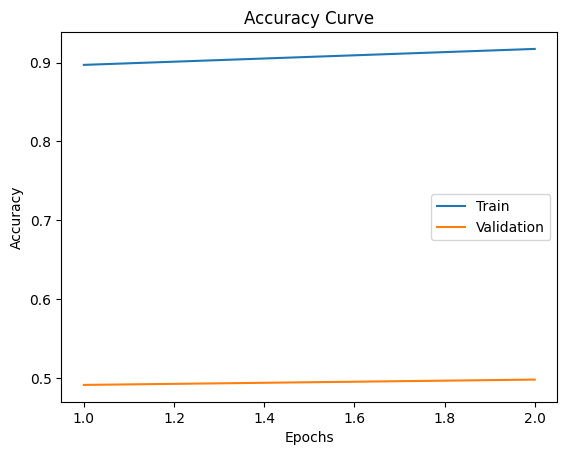

Final Training Accuracy: 0.9173763633647094
Final Validation Accuracy: 0.49790660225442834

Total time elapsed: 10.75 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb10\\chb10_89.edf'
 1 list([(354048, 367872)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb10\\chb10_89.edf'
 1 list([(354048, 367872)])]
Latency:  45.5
Sensitivity:  1.0
FPR:  72057.87358421629

Average latency: 45.5
Average sensitivity: 1.0
Average FPR: 72057.87358421629
Seizure accuracy test complete.


RUNNING ON CHB11

Executing under sampling
3826144
3640
Executing under sampling
1373580
2100
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch 

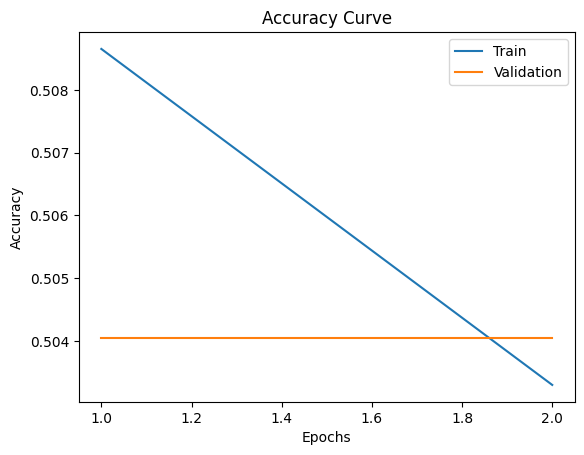

Streaming output truncated to the last 5000 lines.
Batch  3449  complete.
Batch  3450  complete.
Batch  3451  complete.
Batch  3452  complete.
Batch  3453  complete.
Batch  3454  complete.
Batch  3455  complete.
Batch  3456  complete.
Batch  3457  complete.
Batch  3458  complete.
Batch  3459  complete.
Batch  3460  complete.
Batch  3461  complete.
Batch  3462  complete.
Batch  3463  complete.
Batch  3464  complete.
Batch  3465  complete.
Batch  3466  complete.
Batch  3467  complete.
Batch  3468  complete.
Batch  3469  complete.
Batch  3470  complete.
Batch  3471  complete.
Batch  3472  complete.
Batch  3473  complete.
Batch  3474  complete.
Batch  3475  complete.
Batch  3476  complete.
Batch  3477  complete.
Batch  3478  complete.
Batch  3479  complete.
Batch  3480  complete.
Batch  3481  complete.
Batch  3482  complete.
Batch  3483  complete.
Batch  3484  complete.
Batch  3485  complete.
Batch  3486  complete.
Batch  3487  complete.
Batch  3488  complete.
Batch  3489  complete.
Batch 

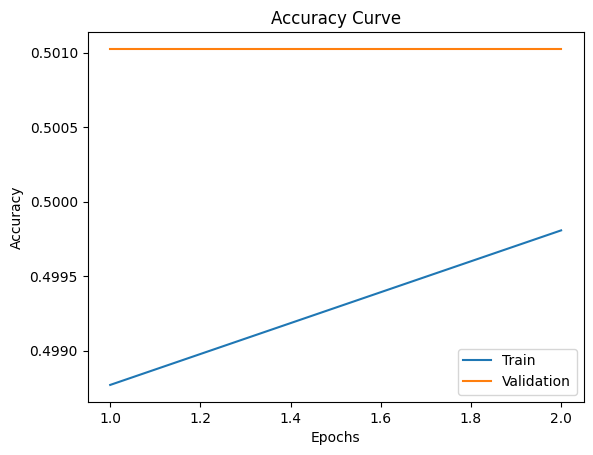

Final Training Accuracy: 0.499807495816736
Final Validation Accuracy: 0.5010245301797319

Total time elapsed: 46.78 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_09.edf'
 2 list([(788992, 797184), (896768, 904960)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_09.edf'
 2 list([(788992, 797184), (896768, 904960)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_11.edf'
 1 list([(277760, 287232)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_11.edf'
 1 list([(277760, 287232)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

['C:\\Users\\assaa\\Documents\\EC

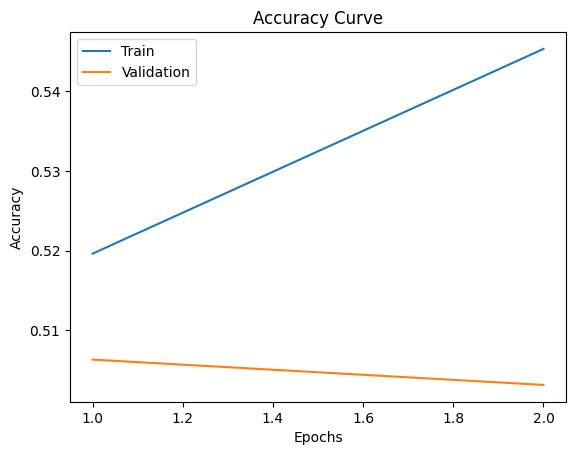

Final Training Accuracy: 0.5453073480923222
Final Validation Accuracy: 0.5031746031746032

Total time elapsed: 10.12 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_55.edf'
 2 list([(117248, 122368), (623616, 628224)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_55.edf'
 2 list([(117248, 122368), (623616, 628224)])]
Latency:  -1
Sensitivity:  -1
FPR:  921600.0

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_62.edf'
 3 list([(217856, 234496), (416256, 432896), (681984, 696576)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_62.edf'
 3 list([(217856, 234496), (416256, 432896), (681984, 696576)

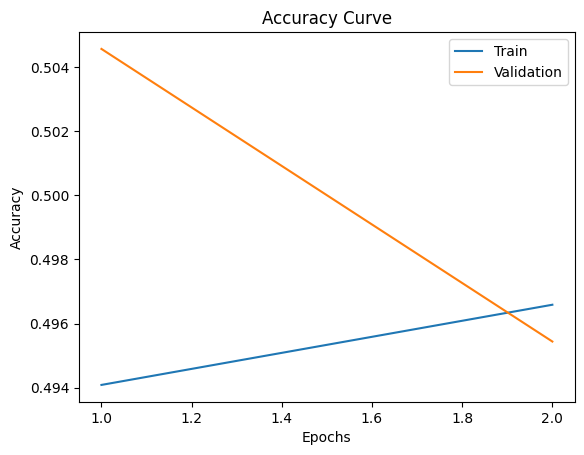

Streaming output truncated to the last 5000 lines.
Batch  928  complete.
Batch  929  complete.
Batch  930  complete.
Batch  931  complete.
Batch  932  complete.
Batch  933  complete.
Batch  934  complete.
Batch  935  complete.
Batch  936  complete.
Batch  937  complete.
Batch  938  complete.
Batch  939  complete.
Batch  940  complete.
Batch  941  complete.
Batch  942  complete.
Batch  943  complete.
Batch  944  complete.
Batch  945  complete.
Batch  946  complete.
Batch  947  complete.
Batch  948  complete.
Batch  949  complete.
Batch  950  complete.
Batch  951  complete.
Batch  952  complete.
Batch  953  complete.
Batch  954  complete.
Batch  955  complete.
Batch  956  complete.
Batch  957  complete.
Batch  958  complete.
Batch  959  complete.
Batch  960  complete.
Batch  961  complete.
Batch  962  complete.
Batch  963  complete.
Batch  964  complete.
Batch  965  complete.
Batch  966  complete.
Batch  967  complete.
Batch  968  complete.
Batch  969  complete.
Batch  970  complete.
Bat

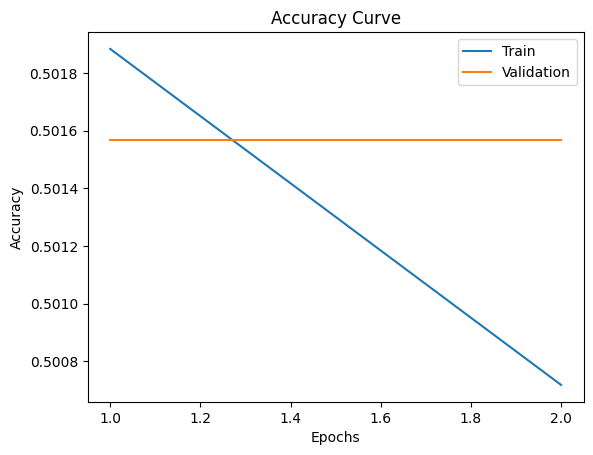

Final Training Accuracy: 0.5007175115012873
Final Validation Accuracy: 0.5015687504902345

Total time elapsed: 66.46 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_22.edf'
 1 list([(194560, 247040)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_22.edf'
 1 list([(194560, 247040)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_28.edf'
 1 list([(224256, 272896)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_28.edf'
 1 list([(224256, 272896)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-d

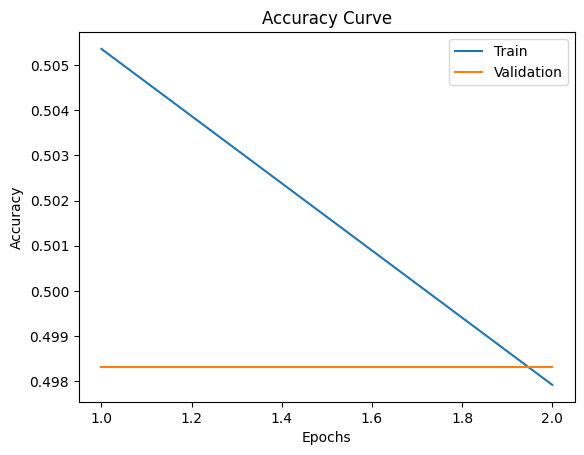

Final Training Accuracy: 0.4979166666666667
Final Validation Accuracy: 0.49831536388140163

Total time elapsed: 3.44 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb16\\chb16_18.edf'
 2 list([(160512, 162560), (488704, 490496)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb16\\chb16_18.edf'
 2 list([(160512, 162560), (488704, 490496)])]
Latency:  -1
Sensitivity:  -1
FPR:  921600.0

Average latency: -1
Average sensitivity: -1
Average FPR: 921600.0
Seizure accuracy test complete.


RUNNING ON CHB17

Executing under sampling
2215136
10584
Executing under sampling
604128
5348
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  compl

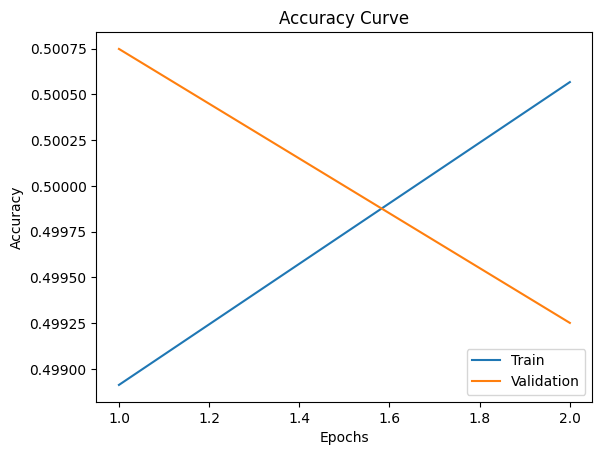

Final Training Accuracy: 0.5005668934240363
Final Validation Accuracy: 0.4992520568436799

Total time elapsed: 8.72 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb17\\chb17a_04.edf'
 1 list([(774400, 803840)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb17\\chb17a_04.edf'
 1 list([(774400, 803840)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB18

Executing under sampling
3624768
13496
Executing under sampling
1165588
1988
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complet

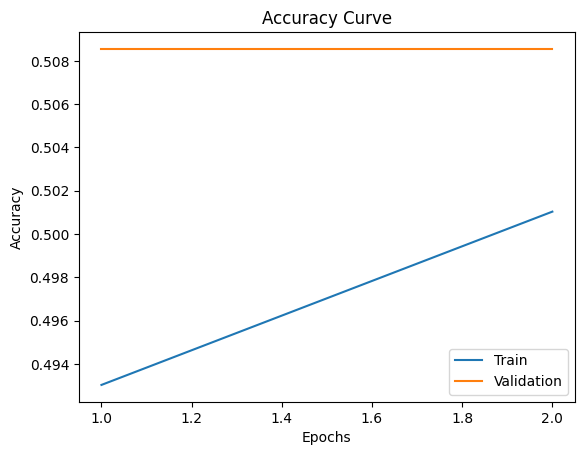

Final Training Accuracy: 0.5010373443983402
Final Validation Accuracy: 0.5085513078470825

Total time elapsed: 8.49 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb18\\chb18_31.edf'
 1 list([(534272, 551680)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb18\\chb18_31.edf'
 1 list([(534272, 551680)])]
Latency:  -1
Sensitivity:  -1
FPR:  921600.0

Average latency: -1
Average sensitivity: -1
Average FPR: 921600.0
Seizure accuracy test complete.


RUNNING ON CHB19

Executing under sampling
3178864
9464
Executing under sampling
1208256
4620
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  

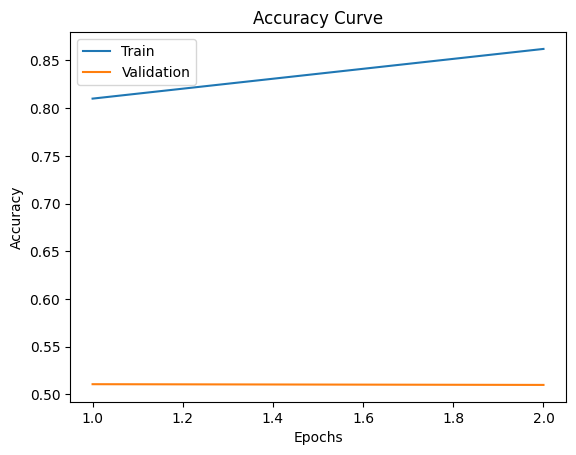

Final Training Accuracy: 0.8620562130177515
Final Validation Accuracy: 0.5098484848484849

Total time elapsed: 7.64 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb19\\chb19_28.edf'
 1 list([(76544, 96512)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb19\\chb19_28.edf'
 1 list([(76544, 96512)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  426308.9820359282

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 426308.9820359282
Seizure accuracy test complete.


RUNNING ON CHB20

Executing under sampling
2820272
14560
Executing under sampling
805504
1932
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  com

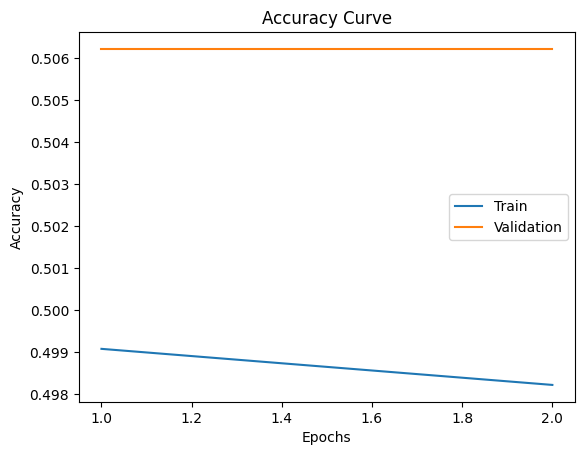

Final Training Accuracy: 0.4982142857142857
Final Validation Accuracy: 0.5062111801242236

Total time elapsed: 9.09 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb20\\chb20_14.edf'
 1 list([(504576, 514304)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb20\\chb20_14.edf'
 1 list([(504576, 514304)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.


RUNNING ON CHB21

Executing under sampling
3423392
7952
Executing under sampling
1208256
3444
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.


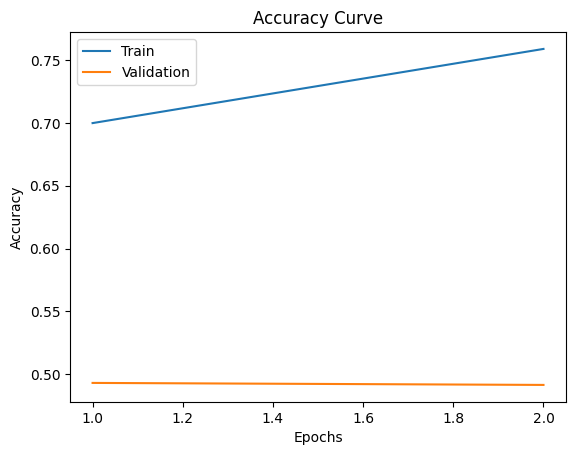

Final Training Accuracy: 0.75886569416499
Final Validation Accuracy: 0.49143437862950057

Total time elapsed: 6.20 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb21\\chb21_22.edf'
 1 list([(653568, 656640)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb21\\chb21_22.edf'
 1 list([(653568, 656640)])]
Latency:  -1
Sensitivity:  0.0
FPR:  533211.4285714286

Average latency: -1
Average sensitivity: 0.0
Average FPR: 533211.4285714286
Seizure accuracy test complete.


RUNNING ON CHB22

Executing under sampling
3424008
7896
Executing under sampling
1006880
3556
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  co

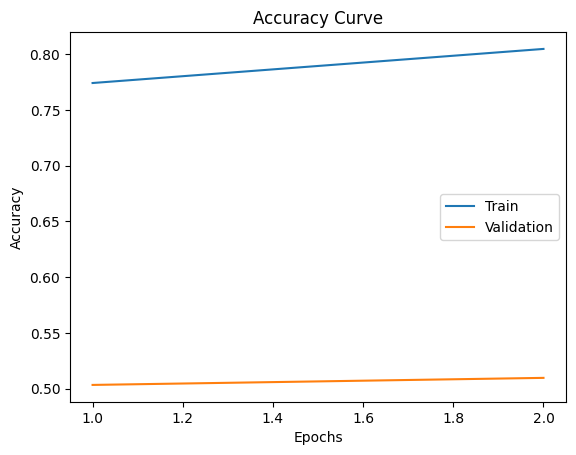

Final Training Accuracy: 0.8046479229989868
Final Validation Accuracy: 0.5095613048368954

Total time elapsed: 6.24 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb22\\chb22_25.edf'
 1 list([(803584, 822528)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb22\\chb22_25.edf'
 1 list([(803584, 822528)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  631374.6630727763

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 631374.6630727763
Seizure accuracy test complete.


RUNNING ON CHB23

Executing under sampling
1672238
9039
Executing under sampling
578818
5451
Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  

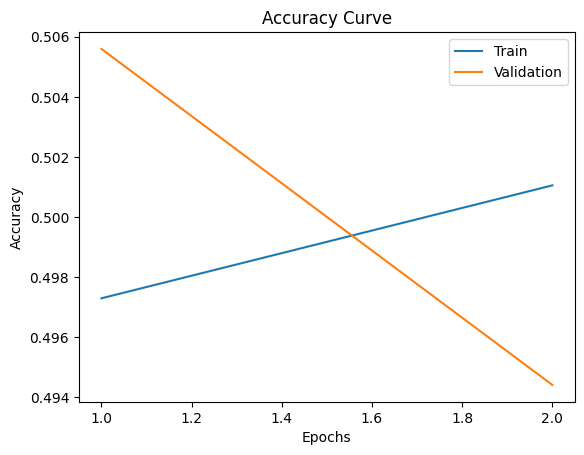

Final Training Accuracy: 0.5010510012169488
Final Validation Accuracy: 0.4944046963859842

Total time elapsed: 7.90 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb23\\chb23_09.edf'
 4
 list([(662784, 680960), (1762560, 1778432), (2177280, 2184192), (2452480, 2473984)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb23\\chb23_09.edf'
 4
 list([(662784, 680960), (1762560, 1778432), (2177280, 2184192), (2452480, 2473984)])]
Latency:  -1
Sensitivity:  -1
FPR:  0.0

Average latency: -1
Average sensitivity: -1
Average FPR: 0.0
Seizure accuracy test complete.




In [27]:
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\cnn_test_results.txt'

for chb in range(1, 23):

  print(f"RUNNING ON CHB{chb+1:02}\n")
  
  train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(chb+1)

  if len(val_seizure_records) == 0:
    val_seizure_records = np.array([train_seizure_records[0].tolist()])

  #Training and validation data separated for the supervised stage.

  X_data = load_data(train_seizure_records, True)
  X_data += under_sample_new(train_interictal_records, len(X_data))
  random.shuffle(X_data)
  X_data = np.asarray(X_data)
  X_train = X_data[:,0]
  Y_train = X_data[:,1]

  X_data = load_data(val_seizure_records, True)
  X_data += under_sample_new(val_interictal_records, len(X_data))
  random.shuffle(X_data)
  X_data = np.asarray(X_data)
  X_val = X_data[:,0]
  Y_val = X_data[:,1]

  print("Initiating Training\n")
  classifier = Classifier()
  classifier.cuda()
  train_classifier(classifier, chb+1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=2)

  torch.save(classifier.state_dict(), fr"C:\Users\assaa\Documents\ECE496\Models\CNN\cnn_chb{chb+1:02}_v4.pth")
  
  # classifier = Classifier()
  # classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb01_32bs_2epochs_v2.pth"))

  print("\nTraining complete.")
  print("Running tests...\n\n")

  test_f = open(save_file, "a")
  test_f.write(f"\n\n\nTest results for CHB{chb+1:02}:\n\n")
  test_f.close()
  
  # test_f.write("Seizure Accuracy:\n")

  test_accuracy(classifier, test_seizure_records, save_file, load_test_data)
  print("Seizure accuracy test complete.\n\n")

  # test_speed(classifier, test_seizure_records, save_file, load_test_data)
  # print("Seizure speed test complete.\n\n\n")

In [23]:
train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(1)
test_seizure_records

C:\Users\assaa\AppData\Local\Temp\ipykernel_47212\2211526169.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)


array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf',
        1, list([(766976, 777216)])]], dtype=object)

RUNNING ON CHB01

Executing under sampling
3335736
15916


C:\Users\assaa\AppData\Local\Temp\ipykernel_44012\2721877465.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
1114810
4094
Initiating Training



C:\Users\assaa\AppData\Local\Temp\ipykernel_44012\2721877465.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

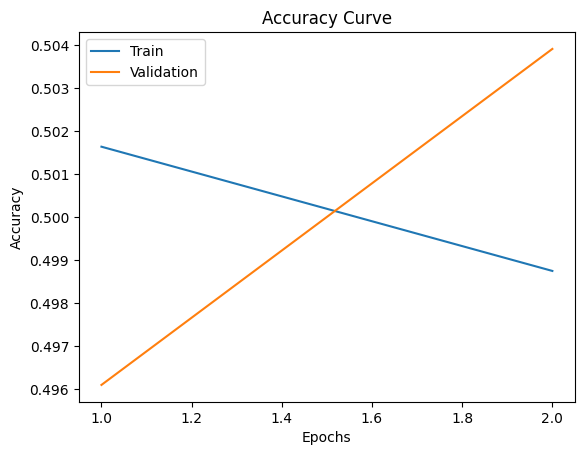

Final Training Accuracy: 0.4987434028650415
Final Validation Accuracy: 0.5039081582804104

Total time elapsed: 11.02 minutes

Training complete.


In [ ]:
chb = 0
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\test_results.txt'

print(f"RUNNING ON CHB{chb+1:02}\n")
  


if len(val_seizure_records) == 0:
  val_seizure_records = np.array([train_seizure_records[0].tolist()])

#Training and validation data separated for the supervised stage.

X_data = load_data(train_seizure_records, True)
X_data += under_sample_new(train_interictal_records, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_train = X_data[:,0]
Y_train = X_data[:,1]

X_data = load_data(val_seizure_records, True)
X_data += under_sample_new(val_interictal_records, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_val = X_data[:,0]
Y_val = X_data[:,1]



# classifier = Classifier()
# classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb01_32bs_2epochs_v2.pth"))

print("\nTraining complete.")

Initiating Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
B

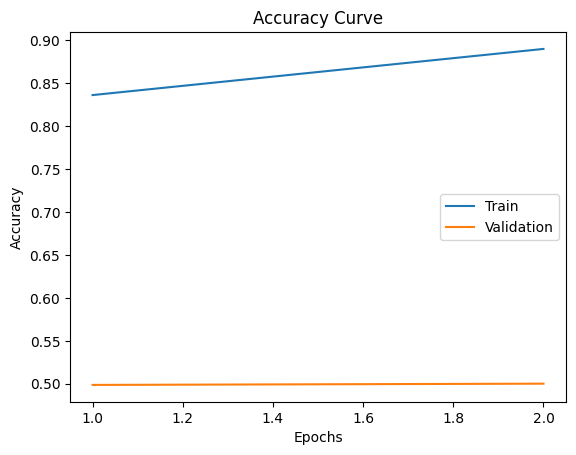

Final Training Accuracy: 0.8897650163357628
Final Validation Accuracy: 0.5001221299462628

Total time elapsed: 11.49 minutes


In [ ]:
print("Initiating Training\n")
classifier = Classifier()
classifier.cuda()
train_classifier(classifier, chb+1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=2)

torch.save(classifier.state_dict(), fr"C:\Users\assaa\Documents\ECE496\Models\CNN\cnn_chb{chb+1:02}_v4.pth")

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

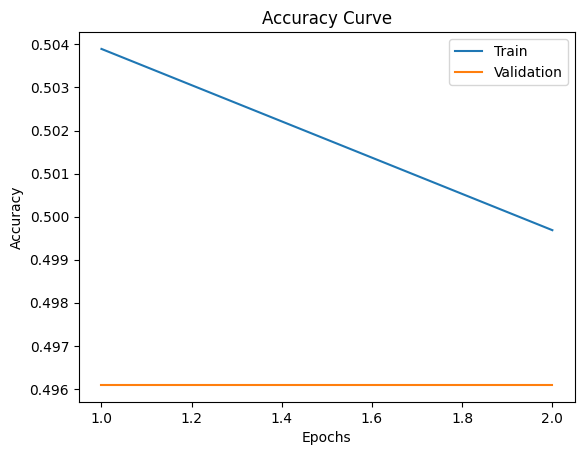

Final Training Accuracy: 0.49968585071626037
Final Validation Accuracy: 0.49609184171958964

Total time elapsed: 11.31 minutes


In [ ]:
classifier.cuda()
train_classifier(classifier, chb+1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=2)

In [ ]:
print("Running tests...\n\n")

test_f = open(save_file, "a")
test_f.write(f"\n\n\nTest results for CHB{chb+1:02}:\n\n")
test_f.close()

# test_f.write("Seizure Accuracy:\n")

test_accuracy(classifier, test_seizure_records, save_file, load_test_data_all)
print("Seizure accuracy test complete.\n\n")

Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_44012\2402554830.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  245541.05912823055

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 245541.05912823055
Seizure accuracy test complete.




In [ ]:
test_speed(classifier, test_seizure_records, save_file)
print("Seizure speed test complete.\n\n\n")

In [ ]:
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\CNN\test_results.txt'


# classifier = Classifier()
# classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\CNN\cnn_chb01_v2.pth"))

# test_f = open(save_file, "a")
# test_f.write("Test results for CHB01_03:\n\n")
# test_f.close()

test_accuracy(classifier, test_seizure_records, save_file, load_test_data_all, capture_saliency=True)
print("Seizure accuracy test complete.\n\n")


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_44012\2402554830.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)
C:\Users\assaa\AppData\Local\Temp\ipykernel_44012\2402554830.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


In [ ]:

test_speed(classifier, test_seizure_records, save_file, load_test_data_all)
print("Seizure speed test complete.\n\n\n")

C:\Users\assaa\AppData\Local\Temp\ipykernel_34484\3961537897.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]
Speed:  157900.133217468

Average speed: 157900.133217468
Seizure speed test complete.



